In [84]:
import numpy as np
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.cluster import MeanShift,estimate_bandwidth

import warnings
warnings.filterwarnings("error", message=".*check_inverse*.",
                        category=UserWarning, append=False)

In [85]:
data=pd.read_csv("C:/Users/kusha/OneDrive/Desktop/Spring 23/Data Science Projects/Outlier Detection Proj/data.csv")

In [86]:
data
data=data.drop(columns=['Unnamed: 0','Provider City','K Means 1'],axis=1)


In [87]:
data

,DRG Definition,Provider Id,Provider Name,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,...,total_discharge_ratio,ratio_average_covered_charges,ratio_average_total_payment,ratio_average_medicare_payments,ratio_oop_payment,ratio_oop_payment_ratio,ratio_payment_coverage,ratio_medicare_pct_paid,region_avg_medicare_paid,Medicare Paid Ratio
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,...,1.338235,0.908445,1.037810,1.038763,1.033356,0.691641,1.128919,5.311252,0.823783,1.000954
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,...,0.509804,0.376065,1.008540,1.080948,0.714704,1.274242,1.873207,4.211412,0.804224,1.069224
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,...,0.873950,0.933470,0.947092,0.967369,0.864809,0.899420,0.708675,4.013431,0.804224,1.018959
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,...,0.910364,0.347893,0.944062,0.896859,1.135614,1.133822,1.895443,3.732842,0.804224,0.947721
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,...,0.655462,0.786167,0.986018,1.053739,0.711205,0.986225,0.876044,4.199175,0.804224,1.066118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123059,"563 - FX, SPRN, STRN & DISL EXCEPT FEMUR, HIP,...",100276,CORAL SPRINGS MEDICAL CENTER,FL,33065,FL - Fort Lauderdale,12,18160.16,4497.16,3561.83,...,0.537931,0.794944,1.068866,1.135692,0.873204,1.323905,1.285319,4.110806,0.746679,1.060721
123060,"563 - FX, SPRN, STRN & DISL EXCEPT FEMUR, HIP,...",100284,WESTCHESTER GENERAL HOSPITAL,FL,33155,FL - Miami,13,16812.23,6835.76,5974.84,...,0.628019,0.621904,1.180026,1.254447,0.835875,1.165304,1.699453,3.653315,0.816679,1.070258
123061,"563 - FX, SPRN, STRN & DISL EXCEPT FEMUR, HIP,...",100286,PHYSICIANS REGIONAL MEDICAL CENTER - PINE RIDGE,FL,34119,FL - Fort Myers,16,28788.75,3928.68,2793.43,...,0.640000,1.398089,0.993899,0.960523,1.086824,1.337693,0.681649,3.551634,0.736815,0.965012
123062,"563 - FX, SPRN, STRN & DISL EXCEPT FEMUR, HIP,...",100287,GOOD SAMARITAN MEDICAL CENTER,FL,33401,FL - Fort Lauderdale,15,21360.80,4319.46,3338.40,...,0.672414,0.935049,1.026631,1.064451,0.915896,1.110907,1.049552,4.011447,0.746679,1.035083


In [88]:
drg_definition_name='DRG Definition'
provider_name='Provider Name'
provider_id_name='Provider Id'
provider_address_name='Provider Street Address'
provider_city_name = 'Provider City'
provider_state_name = 'Provider State'
provider_zip_code_name = 'Provider Zip Code'
hospital_referal_name = 'Hospital Referral Region Description'
total_discharges_name = 'Total Discharges'
average_covered_charges_name = 'Average Covered Charges'
average_total_payment_name = 'Average Total Payments'
average_medicare_payment = 'Average Medicare Payments'
region_name = 'Region'
division_name = 'Division'

In [89]:
# skimming few functions

def normalized(data):
    """ calculates the z score between two datasets """
    mean=data.mean()
    sd=data.std()
    score=(data-mean)/sd
    return score 


def column_scalar(data):
    """scales each column the dataset"""
    new_data=pd.DataFrame()
    for value in data.columns:
        column_data=data[value]
        new_data[value]=normalized(column_data)
    return new_data  




def correlation(dataset,threshold):
    """Remove columns that exceed correlation threshold"""
    col_corr=set()# set of all the deleted columns
    corr_matrix=dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i,j]>=threshold) and (corr_matrix.columns[j] not in col_corr):
                colname=corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname]
    return dataset                
            


def PCA_Col_names(count):
    colname=[]
    rowname=1
    while rowname<=count:
        colname.append(f'Principal Componenet{rowname}')
        rowname+=1
    return colname    






In [90]:
data_subset=data.iloc[:,7:]

In [91]:
data_subset

,Average Covered Charges,Average Total Payments,Average Medicare Payments,Out of Pocket Payment,Coverage Ratio,Out of Pocket per discharge,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_covered_charges_per_drg_state_region,...,total_discharge_ratio,ratio_average_covered_charges,ratio_average_total_payment,ratio_average_medicare_payments,ratio_oop_payment,ratio_oop_payment_ratio,ratio_payment_coverage,ratio_medicare_pct_paid,region_avg_medicare_paid,Medicare Paid Ratio
0,32963.07,5777.24,4763.73,1013.51,5.705678,11.137473,0.175264,0.824568,68.000000,36285.17500,...,1.338235,0.908445,1.037810,1.038763,1.033356,0.691641,1.128919,5.311252,0.823783,1.000954
1,15131.85,5787.57,4976.71,810.86,2.614543,57.918571,0.382476,0.859896,27.461538,40237.35692,...,0.509804,0.376065,1.008540,1.080948,0.714704,1.274242,1.873207,4.211412,0.804224,1.069224
2,37560.37,5434.95,4453.79,981.16,6.910895,40.881667,0.144699,0.819472,27.461538,40237.35692,...,0.873950,0.933470,0.947092,0.967369,0.864809,0.899420,0.708675,4.013431,0.804224,1.018959
3,13998.28,5417.56,4129.16,1288.40,2.583872,51.536000,0.387016,0.762181,27.461538,40237.35692,...,0.910364,0.347893,0.944062,0.896859,1.135614,1.133822,1.895443,3.732842,0.804224,0.947721
4,31633.27,5658.33,4851.44,806.89,5.590566,44.827222,0.178873,0.857398,27.461538,40237.35692,...,0.655462,0.786167,0.986018,1.053739,0.711205,0.986225,0.876044,4.199175,0.804224,1.066118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123059,18160.16,4497.16,3561.83,935.33,4.038140,77.944167,0.247639,0.792018,22.307692,22844.57538,...,0.537931,0.794944,1.068866,1.135692,0.873204,1.323905,1.285319,4.110806,0.746679,1.060721
123060,16812.23,6835.76,5974.84,860.92,2.459453,66.224615,0.406594,0.874056,20.700000,27033.47500,...,0.628019,0.621904,1.180026,1.254447,0.835875,1.165304,1.699453,3.653315,0.816679,1.070258
123061,28788.75,3928.68,2793.43,1135.25,7.327843,70.953125,0.136466,0.711035,25.000000,20591.50000,...,0.640000,1.398089,0.993899,0.960523,1.086824,1.337693,0.681649,3.551634,0.736815,0.965012
123062,21360.80,4319.46,3338.40,981.06,4.945248,65.404000,0.202214,0.772874,22.307692,22844.57538,...,0.672414,0.935049,1.026631,1.064451,0.915896,1.110907,1.049552,4.011447,0.746679,1.035083


In [92]:
data_subset_scaled=column_scalar(data_subset)
data_subset_scaled

,Average Covered Charges,Average Total Payments,Average Medicare Payments,Out of Pocket Payment,Coverage Ratio,Out of Pocket per discharge,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_covered_charges_per_drg_state_region,...,total_discharge_ratio,ratio_average_covered_charges,ratio_average_total_payment,ratio_average_medicare_payments,ratio_oop_payment,ratio_oop_payment_ratio,ratio_payment_coverage,ratio_medicare_pct_paid,region_avg_medicare_paid,Medicare Paid Ratio
0,-0.124464,-0.568217,-0.562234,-0.204067,0.977708,-0.560520,-0.879477,-0.221218,0.869441,-0.028050,...,0.571336,-0.292990,0.241735,0.223923,0.074579,-0.452464,0.409444,2.055751,-0.297330,0.013355
1,-0.657638,-0.566764,-0.530690,-0.373584,-0.645209,0.083804,0.313168,0.170231,-0.467239,0.103869,...,-0.828030,-1.996348,0.054602,0.467589,-0.638053,0.402384,2.772983,1.096668,-0.577546,0.966292
2,0.013001,-0.616358,-0.608139,-0.231128,1.610475,-0.150848,-1.055398,-0.277688,-0.467239,0.103869,...,-0.212924,-0.212920,-0.338245,-0.188460,-0.302359,-0.147590,-0.925070,0.924025,-0.577546,0.264680
3,-0.691533,-0.618804,-0.656219,0.025878,-0.661312,-0.004104,0.339299,-0.912504,-0.467239,0.103869,...,-0.151414,-2.086485,-0.357619,-0.595737,0.303270,0.196346,2.843593,0.679345,-0.577546,-0.729683
4,-0.164226,-0.584941,-0.549244,-0.376905,0.917272,-0.096505,-0.858706,0.142548,-0.467239,0.103869,...,-0.581988,-0.684220,-0.089382,0.310427,-0.645878,-0.020222,-0.393580,1.085998,-0.577546,0.922928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123059,-0.567088,-0.748253,-0.740244,-0.269465,0.102212,0.359620,-0.462911,-0.581897,-0.637177,-0.476682,...,-0.780519,-0.656137,0.440283,0.783801,-0.283585,0.475255,0.906101,1.008938,-1.402024,0.847597
123060,-0.607393,-0.419341,-0.382860,-0.331709,-0.726635,0.198205,0.451985,0.327133,-0.690188,-0.336861,...,-0.628344,-1.209781,1.150954,1.469750,-0.367065,0.242539,2.221213,0.609996,-0.399110,0.980714
123061,-0.249281,-0.828207,-0.854050,-0.102232,1.829382,0.263332,-1.102786,-1.479221,-0.548403,-0.551887,...,-0.608106,1.273635,-0.039002,-0.228005,0.194154,0.495487,-1.010894,0.521328,-1.543349,-0.488332
123062,-0.471385,-0.773246,-0.773336,-0.231212,0.578465,0.186902,-0.724359,-0.794013,-0.637177,-0.476682,...,-0.553354,-0.207868,0.170266,0.372303,-0.188107,0.162723,0.157409,0.922295,-1.402024,0.489736


In [93]:
model_data=correlation(data_subset_scaled,0.5)
model_data

,Average Covered Charges,Out of Pocket Payment,Coverage Ratio,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_trans_per_drg_state_region,mean_oop_per_discharge_drg_state_region,total_discharge_ratio,ratio_average_total_payment,ratio_oop_payment_ratio
0,-0.124464,-0.204067,0.977708,-0.879477,-0.221218,0.869441,-0.954365,-0.859706,0.571336,0.241735,-0.452464
1,-0.657638,-0.373584,-0.645209,0.313168,0.170231,-0.467239,0.050276,-0.153513,-0.828030,0.054602,0.402384
2,0.013001,-0.231128,1.610475,-1.055398,-0.277688,-0.467239,0.050276,-0.153513,-0.212924,-0.338245,-0.147590
3,-0.691533,0.025878,-0.661312,0.339299,-0.912504,-0.467239,0.050276,-0.153513,-0.151414,-0.357619,0.196346
4,-0.164226,-0.376905,0.917272,-0.858706,0.142548,-0.467239,0.050276,-0.153513,-0.581988,-0.089382,-0.020222
...,...,...,...,...,...,...,...,...,...,...,...
123059,-0.567088,-0.269465,0.102212,-0.462911,-0.581897,-0.637177,0.050276,0.169409,-0.780519,0.440283,0.475255
123060,-0.607393,-0.331709,-0.726635,0.451985,0.327133,-0.690188,-0.223717,0.120227,-0.628344,1.150954,0.242539
123061,-0.249281,-0.102232,1.829382,-1.102786,-1.479221,-0.548403,-0.315048,0.029061,-0.608106,-0.039002,0.495487
123062,-0.471385,-0.231212,0.578465,-0.724359,-0.794013,-0.637177,0.050276,0.169409,-0.553354,0.170266,0.162723


In [94]:
pca=PCA()
pca_fit=pca.fit_transform(data_subset_scaled)
explained_ratio=pca.explained_variance_ratio_
print(explained_ratio)
explained_ratio=np.round(explained_ratio,2)
np.cumsum(explained_ratio)


[0.20493829 0.18885413 0.13650097 0.11487182 0.1087491  0.07950062
 0.07576202 0.03831642 0.02038115 0.01709959 0.01502588]


array([0.2 , 0.39, 0.53, 0.64, 0.75, 0.83, 0.91, 0.95, 0.97, 0.99, 1.01])

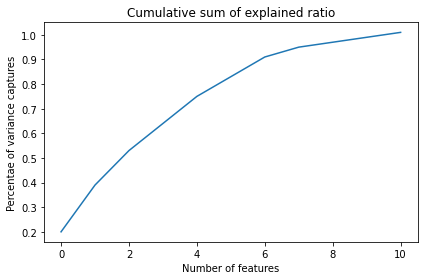

In [95]:
plt.plot(np.cumsum(explained_ratio))
plt.title('Cumulative sum of explained ratio')
plt.xlabel('Number of features')
plt.ylabel('Percentae of variance captures')
plt.tight_layout()
plt.show()

In [96]:
pca_col_names=PCA_Col_names(9)
print(pca_col_names)
pca=PCA(n_components=9)
pca_fit=pca.fit_transform(data_subset_scaled)
pca_dat=pd.DataFrame(pca_fit,columns=pca_col_names)
pca_dat

['Principal Componenet1', 'Principal Componenet2', 'Principal Componenet3', 'Principal Componenet4', 'Principal Componenet5', 'Principal Componenet6', 'Principal Componenet7', 'Principal Componenet8', 'Principal Componenet9']


,Principal Componenet1,Principal Componenet2,Principal Componenet3,Principal Componenet4,Principal Componenet5,Principal Componenet6,Principal Componenet7,Principal Componenet8,Principal Componenet9
0,0.590097,-0.924864,-0.462604,0.911922,-0.216036,-1.538015,0.273047,-0.165009,0.053155
1,-0.968270,0.349994,-0.233285,-0.856105,-0.214837,0.074606,-0.460230,-0.161153,-0.251116
2,1.406232,-0.683629,-0.734416,-0.053512,-0.795789,-0.138801,-0.556828,-0.202902,0.240745
3,-0.811749,0.658691,-0.055490,0.141010,-0.936117,0.221857,-0.301474,0.154179,0.062537
4,0.756554,-0.530490,-0.633056,-0.520971,-0.450531,-0.143450,-0.590549,-0.351331,-0.111378
...,...,...,...,...,...,...,...,...,...
123059,0.069647,0.614741,-0.498428,-0.403403,-0.550092,-0.130293,-0.956573,-0.597515,-0.171221
123060,-0.942064,0.614066,0.439556,-0.765316,0.396000,-0.371816,-0.979860,-0.529899,-0.234339
123061,1.573402,0.405393,-1.212862,0.132014,-1.395209,-0.572431,-0.867924,-0.505639,0.593600
123062,0.548602,0.293854,-0.517849,-0.104691,-0.866168,-0.095614,-0.882799,-0.594762,0.009048


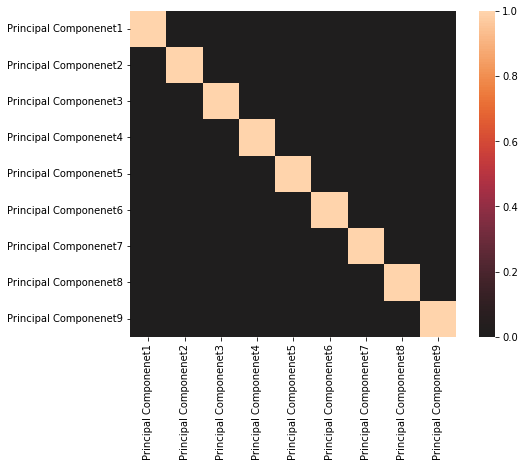

In [97]:
fig=plt.figure(figsize=(8,6))
corr=pca_dat.corr()
sns.heatmap(corr, center=0,
            square=True)
plt.show()

In [98]:
pca.whiten

False

In [ ]:
#   dbscan does a great job of seeking areas in the data that have high density

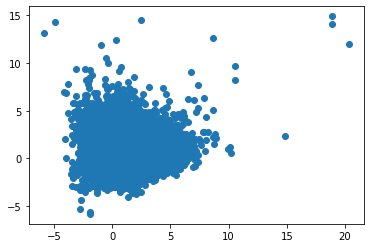

In [99]:
plt.scatter(pca_dat['Principal Componenet4'],pca_dat['Principal Componenet5'])

In [ ]:
# dbscan does a great job of seeking areas in the data that have high density of observations,versus areas that are not very dense with observations.
#eps= how far away can one point be from the next point within the same cluster,min_sample=the minimum number of data points within the same cluster


In [100]:
pca_db=DBSCAN(eps=0.3,min_samples=20).fit(pca_dat)
pca_db_labels=pca_db.labels_
pca_db_labels

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [101]:
len(set(pca_db_labels))

3

In [102]:
pca_db

DBSCAN(eps=0.3, min_samples=20)

In [103]:
cluster,count=np.unique(pca_db_labels,return_counts=True)
dict(zip(cluster,count))

{-1: 123000, 0: 44, 1: 20}

In [104]:
new_labels=[]
for i in pca_db_labels:
    if i==-1:
        new_labels.append("Normal")
    else:
        new_labels.append("Outlier")
np.unique(new_labels,return_counts=True)            

(array(['Normal', 'Outlier'], dtype='<U7'),
 array([123000,     64], dtype=int64))

In [105]:
pca_dat['DB Scan label']=new_labels

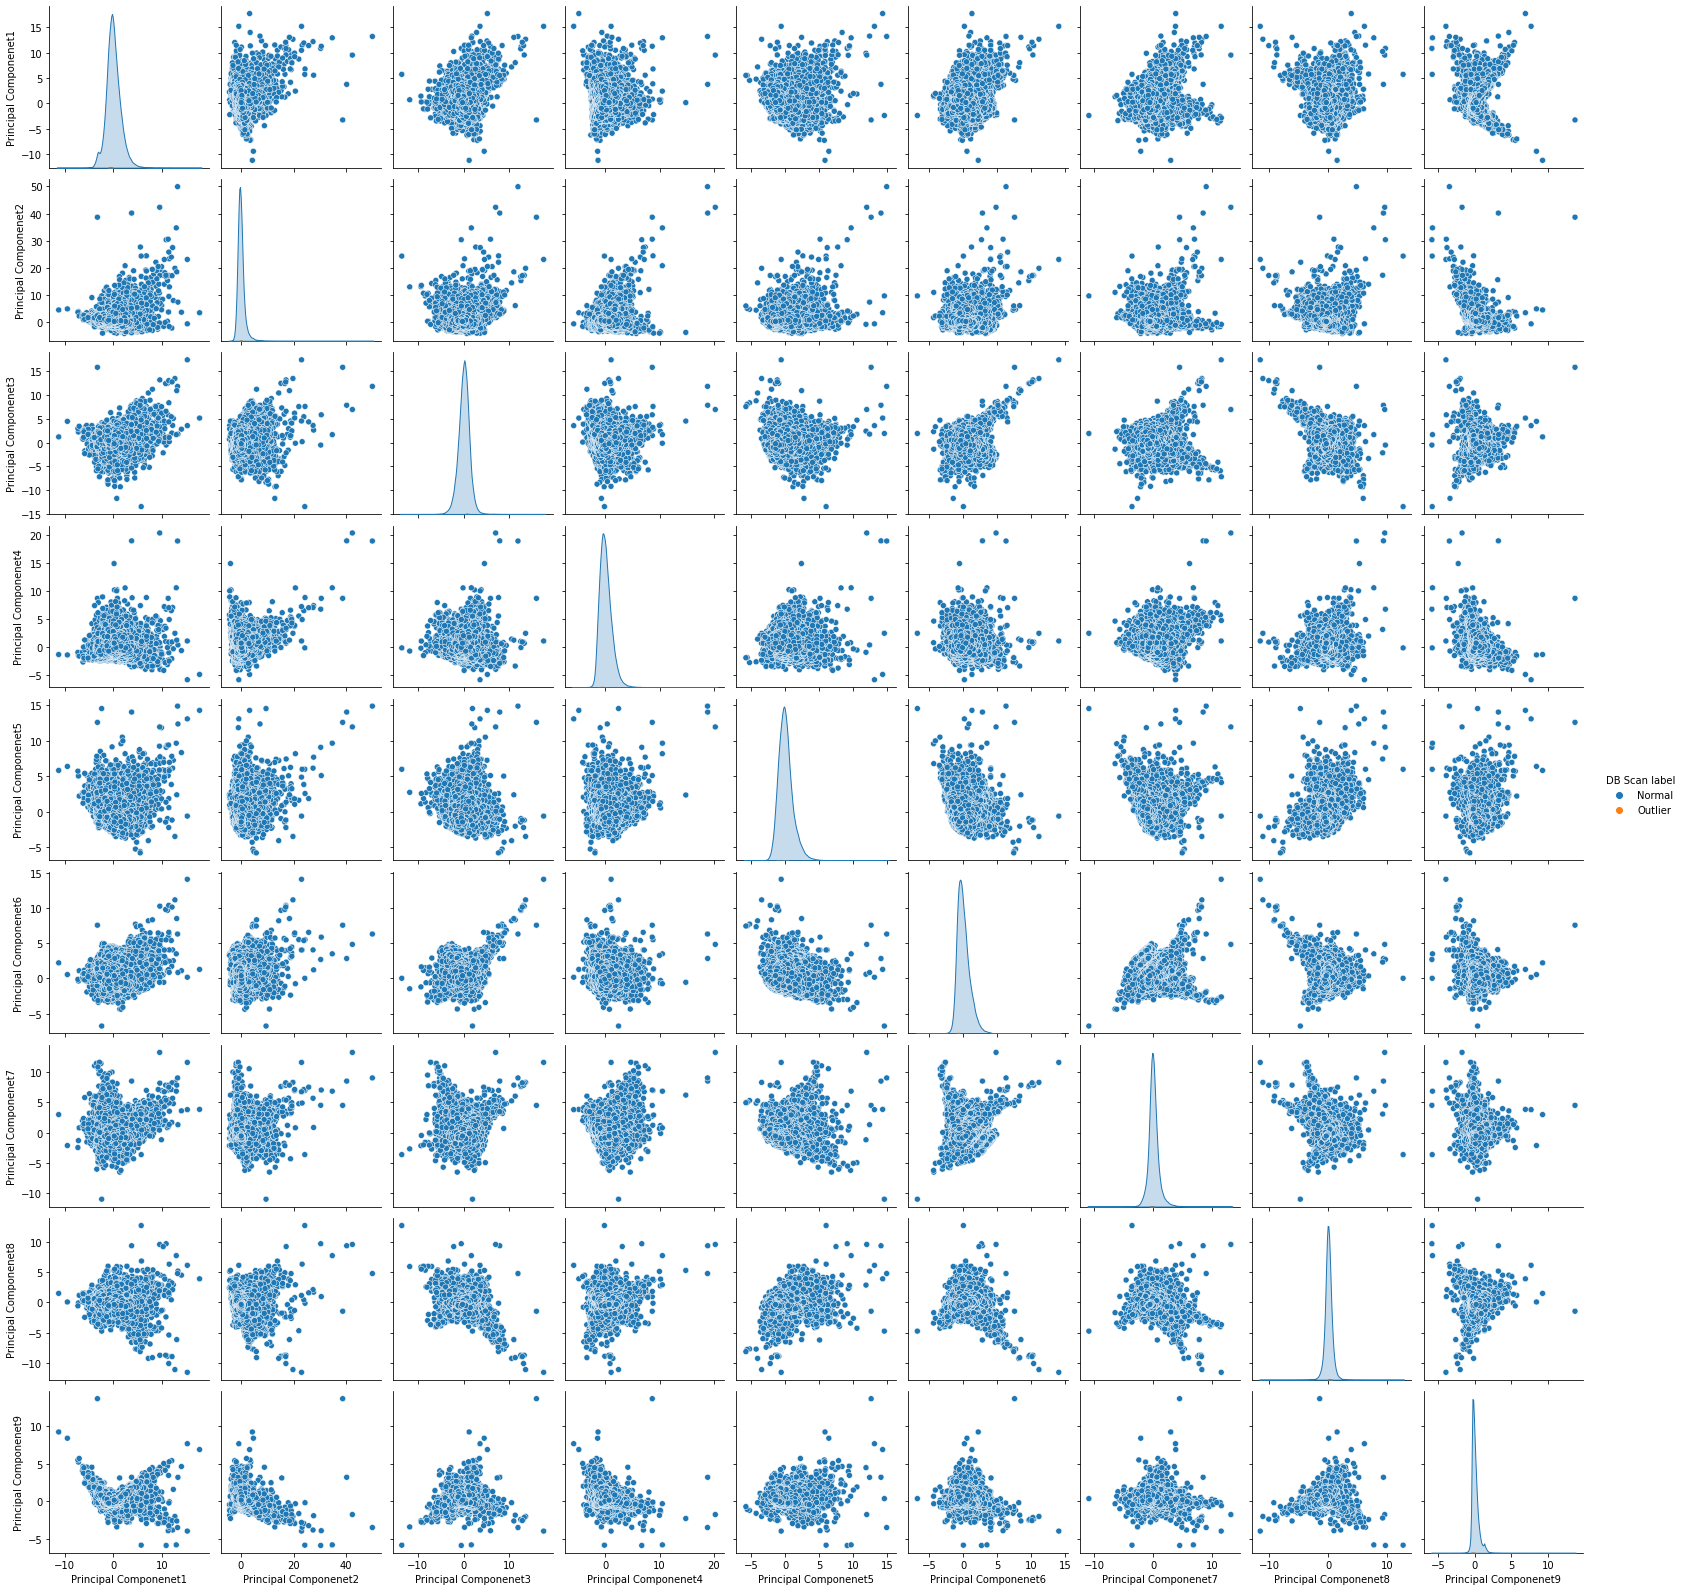

In [45]:
sns.pairplot(pca_dat,hue='DB Scan label')

In [106]:
scaled_db=DBSCAN(eps=0.3,min_samples=20).fit(data_subset_scaled)
scaled_db

DBSCAN(eps=0.3, min_samples=20)

In [107]:
scaled_db_labels=scaled_db.labels_
len(set(scaled_db_labels))

4

In [108]:
scaled_cluster,count=np.unique(scaled_db_labels,return_counts=True)
dict(zip(scaled_cluster,count))

{-1: 123009, 0: 20, 1: 20, 2: 15}

In [109]:
new_labels=[]
for i in scaled_db_labels:
    if i == -1:
        new_labels.append("Normal")
    else:
        new_labels.append('Outlier')
np.unique(new_labels,return_counts=True)            

(array(['Normal', 'Outlier'], dtype='<U7'),
 array([123009,     55], dtype=int64))

In [110]:
data_subset_scaled['DBScan Label']=new_labels

In [111]:
data_subset_scaled

,Average Covered Charges,Out of Pocket Payment,Coverage Ratio,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_trans_per_drg_state_region,mean_oop_per_discharge_drg_state_region,total_discharge_ratio,ratio_average_total_payment,ratio_oop_payment_ratio,DBScan Label
0,-0.124464,-0.204067,0.977708,-0.879477,-0.221218,0.869441,-0.954365,-0.859706,0.571336,0.241735,-0.452464,Normal
1,-0.657638,-0.373584,-0.645209,0.313168,0.170231,-0.467239,0.050276,-0.153513,-0.828030,0.054602,0.402384,Normal
2,0.013001,-0.231128,1.610475,-1.055398,-0.277688,-0.467239,0.050276,-0.153513,-0.212924,-0.338245,-0.147590,Normal
3,-0.691533,0.025878,-0.661312,0.339299,-0.912504,-0.467239,0.050276,-0.153513,-0.151414,-0.357619,0.196346,Normal
4,-0.164226,-0.376905,0.917272,-0.858706,0.142548,-0.467239,0.050276,-0.153513,-0.581988,-0.089382,-0.020222,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...
123059,-0.567088,-0.269465,0.102212,-0.462911,-0.581897,-0.637177,0.050276,0.169409,-0.780519,0.440283,0.475255,Normal
123060,-0.607393,-0.331709,-0.726635,0.451985,0.327133,-0.690188,-0.223717,0.120227,-0.628344,1.150954,0.242539,Normal
123061,-0.249281,-0.102232,1.829382,-1.102786,-1.479221,-0.548403,-0.315048,0.029061,-0.608106,-0.039002,0.495487,Normal
123062,-0.471385,-0.231212,0.578465,-0.724359,-0.794013,-0.637177,0.050276,0.169409,-0.553354,0.170266,0.162723,Normal


In [112]:
data_subset_scaled['DBScan Label'].value_counts()

Normal     123009
Outlier        55
Name: DBScan Label, dtype: int64

C:\Users\kusha\AppData\Roaming\Python\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ratio_oop_payment_ratio', ylabel='total_discharge_ratio'>

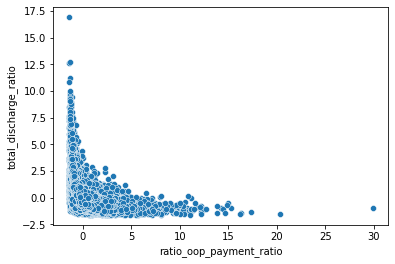

In [123]:
sns.scatterplot('ratio_oop_payment_ratio','total_discharge_ratio',data=data_subset_scaled)

In [132]:
sample=data_subset_scaled[['ratio_oop_payment_ratio','total_discharge_ratio']].loc[data_subset_scaled['ratio_oop_payment_ratio']>15]
sample

,ratio_oop_payment_ratio,total_discharge_ratio
30974,17.361012,-1.353204
42300,15.254424,-1.001057
53332,29.920892,-0.975442
62800,16.312245,-1.393244
104044,20.326921,-1.495451
113736,16.184485,-1.509950


In [136]:
data_subset_scaled['ratio_oop_payment_ratio'].min()

-1.4673070211817167

In [137]:
data_subset_scaled.loc[data_subset_scaled['ratio_oop_payment_ratio']==-1.4673070211817167]

,Average Covered Charges,Out of Pocket Payment,Coverage Ratio,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_trans_per_drg_state_region,mean_oop_per_discharge_drg_state_region,total_discharge_ratio,ratio_average_total_payment,ratio_oop_payment_ratio,DBScan Label
90877,-0.429051,-1.051868,-0.37958,-0.043757,1.722648,-0.769794,-0.49771,-0.184057,-0.48828,-0.943094,-1.467307,Normal


In [134]:
data_subset_scaled.iloc[53332]

Average Covered Charges                     3.071698
Out of Pocket Payment                      12.952669
Coverage Ratio                              0.604158
Payment Covered Percentage                 -0.735764
Medicare % Paid                            -4.901834
mean_discharge_per_drg_state_region        -0.436295
mean_trans_per_drg_state_region             3.429523
mean_oop_per_discharge_drg_state_region     0.322061
total_discharge_ratio                      -0.975442
ratio_average_total_payment                 4.575139
ratio_oop_payment_ratio                    29.920892
DBScan Label                                  Normal
Name: 53332, dtype: object

In [68]:
data_subset_scaled['DBScan Label'].value_counts()

Normal     123009
Outlier        55
Name: DBScan Label, dtype: int64

In [69]:
pca_dat['DB Scan label'].value_counts()

Normal     123000
Outlier        64
Name: DB Scan label, dtype: int64

In [83]:
color= ['red' if l == 'Normal' else 'green' for l in new_labels]

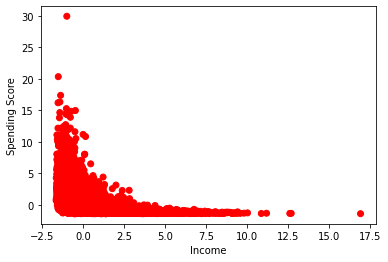

In [80]:
# work on this 
# plt.scatter(data_subset_scaled['total_discharge_ratio'],data_subset_scaled['ratio_oop_payment_ratio'], c=color,cmap= "plasma") # plotting the clusters
# plt.xlabel("Income") # X-axis label
# plt.ylabel("Spending Score") # Y-axis label
# plt.show()

In [75]:
new_labels

['Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',

In [71]:
pca_dat

,Principal Componenet1,Principal Componenet2,Principal Componenet3,Principal Componenet4,Principal Componenet5,Principal Componenet6,Principal Componenet7,Principal Componenet8,Principal Componenet9,DB Scan label
0,0.590097,-0.924864,-0.462604,0.911922,-0.216036,-1.538015,0.273047,-0.165009,0.053155,Normal
1,-0.968270,0.349994,-0.233285,-0.856105,-0.214837,0.074606,-0.460230,-0.161153,-0.251116,Normal
2,1.406232,-0.683629,-0.734416,-0.053512,-0.795789,-0.138801,-0.556828,-0.202902,0.240745,Normal
3,-0.811749,0.658691,-0.055490,0.141010,-0.936117,0.221857,-0.301474,0.154179,0.062537,Normal
4,0.756554,-0.530490,-0.633056,-0.520971,-0.450531,-0.143450,-0.590549,-0.351331,-0.111378,Normal
...,...,...,...,...,...,...,...,...,...,...
123059,0.069647,0.614741,-0.498428,-0.403403,-0.550092,-0.130293,-0.956573,-0.597515,-0.171221,Normal
123060,-0.942064,0.614066,0.439556,-0.765316,0.396000,-0.371816,-0.979860,-0.529899,-0.234339,Normal
123061,1.573402,0.405393,-1.212862,0.132014,-1.395209,-0.572431,-0.867924,-0.505639,0.593600,Normal
123062,0.548602,0.293854,-0.517849,-0.104691,-0.866168,-0.095614,-0.882799,-0.594762,0.009048,Normal


In [138]:
data_subset_scaled

,Average Covered Charges,Out of Pocket Payment,Coverage Ratio,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_trans_per_drg_state_region,mean_oop_per_discharge_drg_state_region,total_discharge_ratio,ratio_average_total_payment,ratio_oop_payment_ratio,DBScan Label
0,-0.124464,-0.204067,0.977708,-0.879477,-0.221218,0.869441,-0.954365,-0.859706,0.571336,0.241735,-0.452464,Normal
1,-0.657638,-0.373584,-0.645209,0.313168,0.170231,-0.467239,0.050276,-0.153513,-0.828030,0.054602,0.402384,Normal
2,0.013001,-0.231128,1.610475,-1.055398,-0.277688,-0.467239,0.050276,-0.153513,-0.212924,-0.338245,-0.147590,Normal
3,-0.691533,0.025878,-0.661312,0.339299,-0.912504,-0.467239,0.050276,-0.153513,-0.151414,-0.357619,0.196346,Normal
4,-0.164226,-0.376905,0.917272,-0.858706,0.142548,-0.467239,0.050276,-0.153513,-0.581988,-0.089382,-0.020222,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...
123059,-0.567088,-0.269465,0.102212,-0.462911,-0.581897,-0.637177,0.050276,0.169409,-0.780519,0.440283,0.475255,Normal
123060,-0.607393,-0.331709,-0.726635,0.451985,0.327133,-0.690188,-0.223717,0.120227,-0.628344,1.150954,0.242539,Normal
123061,-0.249281,-0.102232,1.829382,-1.102786,-1.479221,-0.548403,-0.315048,0.029061,-0.608106,-0.039002,0.495487,Normal
123062,-0.471385,-0.231212,0.578465,-0.724359,-0.794013,-0.637177,0.050276,0.169409,-0.553354,0.170266,0.162723,Normal


In [97]:
#elliptical envelope

%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.metrics import average_precision_score, confusion_matrix, f1_score, precision_recall_curve, accuracy_score, precision_score, recall_score
from collections import Counter

In [96]:
data_ee=pd.read_csv("C:/Users/kusha/OneDrive/Desktop/Spring 23/Data Science Projects/Outlier Detection Proj/kddcup.data_10_percent.csv")

In [98]:
data_ee=data_ee[['duration','src_bytes','dst_bytes','logged_in','label']]

In [99]:
data_ee.head()

,duration,src_bytes,dst_bytes,logged_in,label
0,0,239,486,1,normal.
1,0,235,1337,1,normal.
2,0,219,1337,1,normal.
3,0,217,2032,1,normal.
4,0,217,2032,1,normal.


<AxesSubplot:>

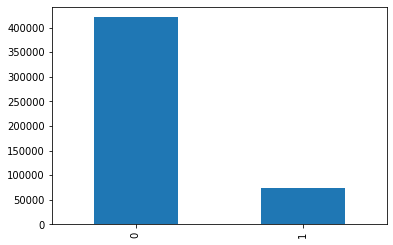

In [100]:
data_ee['logged_in'].value_counts().plot(kind="bar")

In [101]:
data_ee.dtypes

duration      int64
src_bytes     int64
dst_bytes     int64
logged_in     int64
label        object
dtype: object

In [102]:
print(data_ee.describe())

            duration     src_bytes     dst_bytes      logged_in
count  494020.000000  4.940200e+05  4.940200e+05  494020.000000
mean       47.979400  3.025616e+03  8.685232e+02       0.148245
std       707.747185  9.882191e+05  3.304003e+04       0.355343
min         0.000000  0.000000e+00  0.000000e+00       0.000000
25%         0.000000  4.500000e+01  0.000000e+00       0.000000
50%         0.000000  5.200000e+02  0.000000e+00       0.000000
75%         0.000000  1.032000e+03  0.000000e+00       0.000000
max     58329.000000  6.933756e+08  5.155468e+06       1.000000


In [103]:
data_ee['label']=np.where(data_ee['label']=='normal.',1,-1)

In [104]:
frac = Counter(data_ee.label)
print(frac)

Counter({-1: 396743, 1: 97277})


In [105]:
x_train,x_test,y_train,y_test=train_test_split(data_ee.iloc[:,0:3],data_ee['label'],test_size=0.2,random_state=2000)

In [106]:
x_train,x_test,y_train,y_test

(        duration  src_bytes  dst_bytes
 389030         0          0          0
 371521         0        105        146
 99487          0       1032          0
 129634         0       1032          0
 444889         0        520          0
 ...          ...        ...        ...
 165430         0       1032          0
 331725         0       1032          0
 324814         0       1032          0
 430920         0        520          0
 355254         0          0          0
 
 [395216 rows x 3 columns],
         duration  src_bytes  dst_bytes
 139554         0        245        198
 233260         0       1032          0
 17923          0        215       5267
 119678         0          0          0
 1807           0        229       1284
 ...          ...        ...        ...
 262607         0       1032          0
 433043         0        520          0
 314554         0       1032          0
 8465           0       1032          0
 253407         0       1032          0
 
 [98804 

In [107]:
print('Shape of Training Data:',x_train.shape)
print('Shape of Training Labels:',y_train.shape)
print('Shape of Test Data:',x_test.shape)
print('Shape of Test Labels:',y_test.shape)

Shape of Training Data: (395216, 3)
Shape of Training Labels: (395216,)
Shape of Test Data: (98804, 3)
Shape of Test Labels: (98804,)


In [108]:
x_train

,duration,src_bytes,dst_bytes
389030,0,0,0
371521,0,105,146
99487,0,1032,0
129634,0,1032,0
444889,0,520,0
...,...,...,...
165430,0,1032,0
331725,0,1032,0
324814,0,1032,0
430920,0,520,0


In [109]:
ee=EllipticEnvelope(contamination=0.04)
ee.fit(x_train)

C:\Users\kusha\AppData\Roaming\Python\Python310\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (33.428132322771340 > 29.169002081340679). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(


EllipticEnvelope(contamination=0.04)

In [110]:
y_pred_train=ee.predict(x_train)
y_pred_test=ee.predict(x_test)

In [111]:
accuracy_score(y_train,y_pred_train)

0.1673565847536537

In [63]:
ee.predict([[0,0,4]])

C:\Users\kusha\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but EllipticEnvelope was fitted with feature names
  warnings.warn(


array([1])

In [67]:
set(ee.decision_function(x_train))

{-338670.8473700446,
 52104.95777763039,
 52104.99921288253,
 52104.19785675623,
 54055.010111193966,
 5.180196019879077,
 -262129.50848905212,
 -1310704.7233131684,
 52106.3855364334,
 52107.48269850244,
 24.2589068370944,
 52108.46067741404,
 52108.86350597572,
 -262117.3638692408,
 52108.8265476259,
 54056.62875286278,
 52110.265990758104,
 -131028.71844118641,
 52112.76232391218,
 -131026.72827113295,
 52112.28115291453,
 52112.72886128765,
 52112.792091882446,
 -9568209.253551213,
 52112.7661214891,
 52112.48733090093,
 52112.80127029987,
 52112.52627277717,
 -131020.23092368111,
 -9568195.564748293,
 52119.33458022272,
 54058.70632102781,
 -1310638.2761518925,
 54438.771262758426,
 52120.49363391937,
 52120.60716602986,
 54088.68212147447,
 52120.39713083625,
 52120.18294729798,
 52120.565726360495,
 52120.153645593266,
 52120.48757767407,
 52120.18869044368,
 94.32636588323658,
 54426.445841099405,
 99.95422796047205,
 102.50112178366544,
 103.68120782262122,
 -37422628760.41117

In [65]:
y_train_anomaly_score=ee.decision_function(x_train)
y_test_anomaly_score=ee.decision_function(x_test)

In [82]:
y_train_anomaly_score

array([54548.05990885, 54521.58743741, 54564.42182736, ...,
       54564.42182736, 54561.50462983, 54548.05990885])

{'whiskers': [<matplotlib.lines.Line2D at 0x23ac043c970>,
 'caps': [<matplotlib.lines.Line2D at 0x23ac043cf10>,
 'boxes': [<matplotlib.lines.Line2D at 0x23ac043c6a0>],
 'medians': [<matplotlib.lines.Line2D at 0x23ac043d4b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x23ac043d780>],
 'means': []}

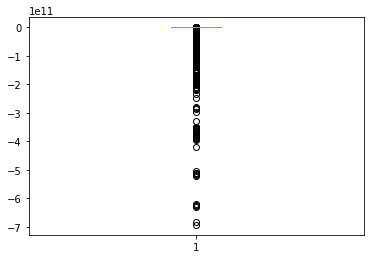

In [66]:
plt.boxplot(y_train_anomaly_score)

{'whiskers': [<matplotlib.lines.Line2D at 0x23ac032f100>,
 'caps': [<matplotlib.lines.Line2D at 0x23ac032f6a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x23ac032ef50>],
 'medians': [<matplotlib.lines.Line2D at 0x23ac032fc40>],
 'fliers': [<matplotlib.lines.Line2D at 0x23ac032ff10>],
 'means': []}

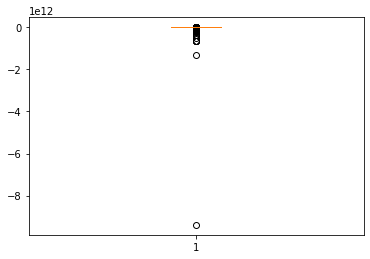

In [68]:
plt.boxplot(y_test_anomaly_score)

In [75]:
y_pred_train=ee.predict(x_train)
y_pred_test=ee.predict(x_test)

In [77]:
set(y_pred_test)

{-1, 1}

In [78]:
y_pred_train

array([1, 1, 1, ..., 1, 1, 1])

In [83]:
accuracy_score(y_pred_train,y_train)

0.1673565847536537

In [80]:
print(precision_score(y_pred_train,y_train))

0.822726048652877


In [81]:
print("Area Under the Precision-Recall Curve (AUPRC): {:.3f}".format(average_precision_score(y_train, y_pred_train)))

Area Under the Precision-Recall Curve (AUPRC): 0.174


In [92]:
print(Counter(y_train))
print(Counter(y_test))
print(Counter(y_pred_train))
print(Counter(y_pred_test))

Counter({-1: 317235, 1: 77981})
Counter({-1: 79508, 1: 19296})
Counter({1: 379407, -1: 15809})
Counter({1: 94791, -1: 4013})


In [91]:
y_pred_train.shape

(395216,)

In [88]:
y_pred_test.shape

(98804,)

In [93]:
print(Counter(y_test))

Counter({-1: 79508, 1: 19296})


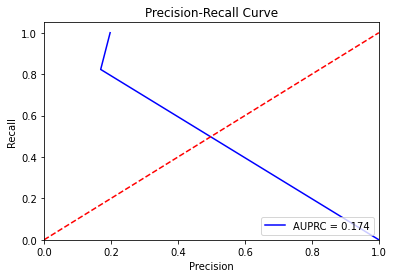

In [94]:
precision, recall, _ = precision_recall_curve(y_train, y_pred_train)
auprc = average_precision_score(y_train, y_pred_train)
plt.title('Precision-Recall Curve')
plt.plot(precision, recall, 'b', label = 'AUPRC = %0.3f' % auprc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.show()

In [95]:
print("f1 Score: {:.3f}".format(f1_score(y_test, y_pred_test)))  

f1 Score: 0.277
